# Noctis Mons Topographic Analysis — Mars MOLA DEM and QGIS shapefiles

**Author:** *Faris Beg*\
**Institute:** Institute of Space Research (PF), German Aerospace Center (DLR)

**Description:** This notebook loads Mars Orbiter Laser Altimeter (MOLA) spherical harmonic topography data and QGIS-sampled elevation shapefiles to (1) extract a regional DEM centred on Noctis Mons, (2) interpolate base and raised surface levels using Radial Basis Functions, and (3) compute a thickness grid representing the relief between the two surfaces.

In [1]:
# Standard library & scientific stack 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

# Geospatial & interpolation
import geopandas as gpd
from scipy.interpolate import Rbf

# Planetary data (spherical harmonics)
import pyshtools as pysh

plt.rcParams.update({'font.size': 10})

## 1. Loading Input Data

### 1a. QGIS-sampled shapefiles
Two point shapefiles are loaded — one for the **base** (low/exposed) surface and one for the **raised** (high) surface. Each contains X/Y coordinates and sampled elevation values extracted in QGIS.

### 1b. MOLA spherical harmonic model
The MOLA shape model is loaded as spherical harmonic (SH) coefficients via `pyshtools`. Two SH terms are zeroed out before expansion:
- `coeffs[0,0,0]` — the degree-0 term sets the mean planetary radius; zeroing it re-centres all elevations around **0 m** (deviations from the global mean).
- `coeffs[0,2,0]` — the C₂₀ zonal term representing Mars's polar flattening; removing it isolates local relief from the planetary oblate shape.

The coefficients are then expanded into a Driscoll–Healy (DH) spatial grid at `lmax = 2500`.

In [2]:
#  Load QGIS-sampled shapefiles 
base_points   = r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\base elevations_2.shp"
raised_points = r"C:\Users\DELL\Downloads\Volume and Interpolation _Project_layers\elevations_2\raised elevations_2.shp"

base_layer   = gpd.read_file(base_points)
raised_layer = gpd.read_file(raised_points)

# Extract coordinate and elevation arrays from the attribute table
x_b = base_layer['X'].values
y_b = base_layer['Y'].values
z_b = base_layer['elevations'].values

#  Load MOLA spherical harmonic coefficients 
mola_sh = pysh.datasets.Mars.MOLA_shape()   # Default lmax; pass lmax=3000 for full resolution
mola_sh.coeffs[0, 0, 0] = 0                 # Remove mean planetary radius → elevations relative to 0 m
mola_sh.coeffs[0, 2, 0] = 0                 # Remove C20 zonal flattening term

# Expand SH coefficients into a global elevation grid (DH convention: lat 90°→−90°, lon 0°→360°)
mola_grid_obj = mola_sh.expand(grid='DH', lmax=2500)
mola_grid     = mola_grid_obj.data

# Retrieve the latitude and longitude axes of the DH grid
lat_mola = mola_grid_obj.lats()
lon_mola = mola_grid_obj.lons()

# Save the global grid for reuse
np.save('MOLA_GlobalGrid_lmax%i' % mola_sh.lmax, mola_grid)

print("Max SH degree available:", mola_sh.lmax)
print("Global MOLA grid shape:",  mola_grid.shape)

Max SH degree available: 719
Global MOLA grid shape: (5003, 5003)


## 2. Extracting the Noctis Mons Regional DEM

The spatial extent of the study area is derived from the bounding box of the base-level sample points. Longitudes are shifted to the 0–360° range to match the DH grid convention. Index arrays are used to slice the relevant rows and columns from the global grid.

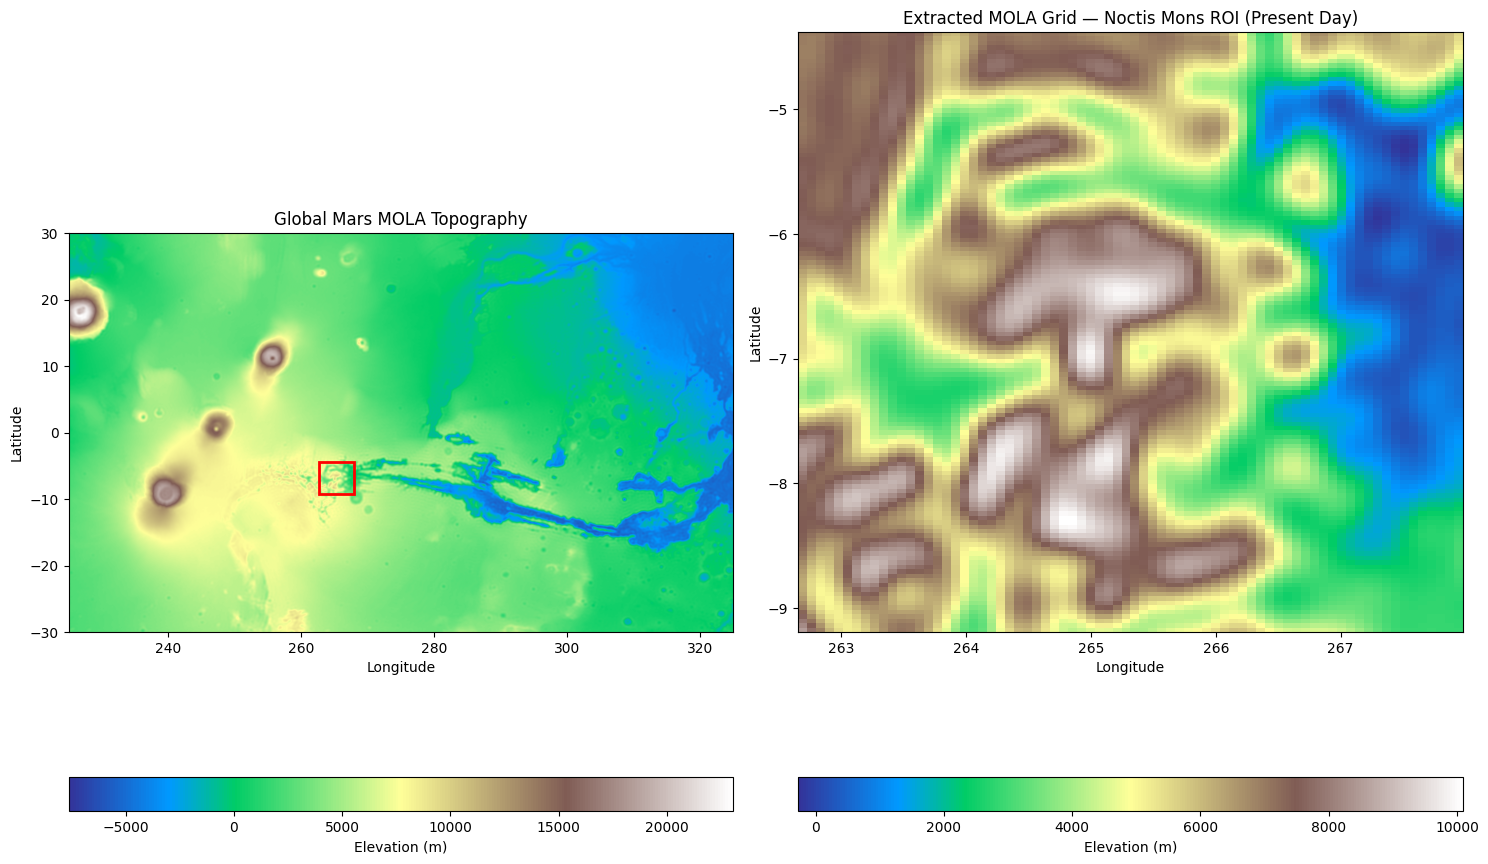

In [3]:
# Define study-area extent in DH coordinates (longitudes shifted to 0–360° range)
lon_min, lon_max = np.min(x_b) + 360, np.max(x_b) + 360
lat_min, lat_max = np.min(y_b), np.max(y_b)

# Find grid indices that fall within the bounding box
lon_inds = np.where((lon_mola >= lon_min) & (lon_mola <= lon_max))[0]
lat_inds = np.where((lat_mola >= lat_min) & (lat_mola <= lat_max))[0]

# Extract the Noctis Mons subgrid from the global DEM
grid_noctis = mola_grid[np.ix_(lat_inds, lon_inds)]
np.save('grid_noctis_lmax%i.npy' % mola_sh.lmax, grid_noctis)

#  Plot: global context map (zoomed) + extracted regional DEM 
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Left panel — global MOLA topography, zoomed to the equatorial Tharsis region
ax1 = axes[0]
im1 = ax1.imshow(mola_grid, cmap='terrain', origin='upper',
                 extent=[np.min(lon_mola), np.max(lon_mola),
                         np.min(lat_mola), np.max(lat_mola)])
ax1.set_xlim(225, 325)
ax1.set_ylim(-30, 30)

# Annotate the study-area footprint
polygon_vertices = [
    (lon_min, lat_min), (lon_max, lat_min),
    (lon_max, lat_max), (lon_min, lat_max), (lon_min, lat_min)
]
polygon = patches.Polygon(polygon_vertices, edgecolor='red',
                           facecolor='none', closed=True, linewidth=2.0)
arrow   = patches.FancyArrow(-7, 265, 5, -10, color='blue', width=1.0, lw=5)
ax1.add_patch(polygon)
ax1.add_patch(arrow)

ax1.set_title('Global Mars MOLA Topography')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(im1, ax=ax1, orientation='horizontal').set_label('Elevation (m)')

# Right panel — extracted Noctis Mons subgrid
ax2 = axes[1]
im2 = ax2.imshow(grid_noctis, origin='upper', cmap='terrain',
                 extent=[lon_min, lon_max, lat_min, lat_max])
ax2.set_title('Extracted MOLA Grid — Noctis Mons ROI (Present Day)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
fig.colorbar(im2, ax=ax2, orientation='horizontal').set_label('Elevation (m)')

plt.tight_layout()
plt.savefig('noctis_mons_extract.png', dpi=300)
plt.show()

## 3. Base Surface Interpolation

The QGIS base-level sample points are interpolated onto a regular grid matching the resolution and extent of `grid_noctis` using a **Radial Basis Function (RBF)** with a linear kernel. A linear kernel was chosen over Thin-Plate Spline (TPS) to minimise artificial smoothing and better preserve the true surface geometry.

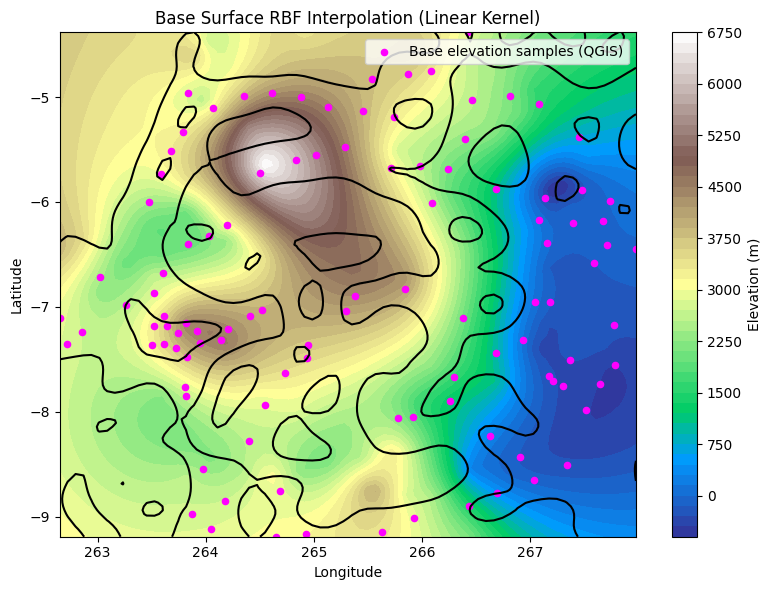

Interpolated base surface range: -589.5 m to 6743.4 m


In [13]:
# Shift base-layer longitudes to 0–360° range to match the DH grid
x_b = base_layer['X'].values + 360
y_b = base_layer['Y'].values
z_b = base_layer['elevations'].values

# Create an output grid with the same resolution as the extracted MOLA subgrid
grid_x_b, grid_y_b = np.meshgrid(
    np.linspace(min(x_b), max(x_b), np.shape(grid_noctis)[1]),
    np.linspace(min(y_b), max(y_b), np.shape(grid_noctis)[0])
)

# RBF interpolation — maps known sample coordinates to a continuous base surface
rbf_interpolator  = Rbf(x_b, y_b, z_b, function='linear')
grid_z_spline_b   = rbf_interpolator(grid_x_b, grid_y_b)

#  Plot: interpolated base surface with MOLA contours for geological context 
fig, ax2 = plt.subplots(1, figsize=(8, 6))

# Filled contour of the interpolated base surface (grid rows reversed to match imshow orientation)
contour = ax2.contourf(grid_x_b, grid_y_b, grid_z_spline_b[::-1],
                       cmap='terrain', levels=50, origin='upper')

# MOLA contour lines overlaid for topographic reference
ax2.contour(grid_x_b, grid_y_b, grid_noctis[::-1], levels=3, colors='k', origin='upper')

# Sample point locations
ax2.scatter(x_b, y_b, c='magenta', s=20, label='Base elevation samples (QGIS)')

fig.colorbar(contour, ax=ax2).set_label('Elevation (m)')
ax2.set_title('Base Surface RBF Interpolation (Linear Kernel)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.legend()
plt.tight_layout()
plt.show()

print(f'Interpolated base surface range: {np.min(grid_z_spline_b):.1f} m to {np.max(grid_z_spline_b):.1f} m')

## 4. Thickness Grid

The thickness (relief) at each grid point is computed by subtracting the interpolated base surface from the present-day MOLA topography:

$$\text{thickness} = \text{MOLA}_{\text{present}} - \text{base surface}_{\text{interpolated}}$$

This represents the height of existing raised features (volcanic edifice, etc.) above the reconstructed pre-existing surface.

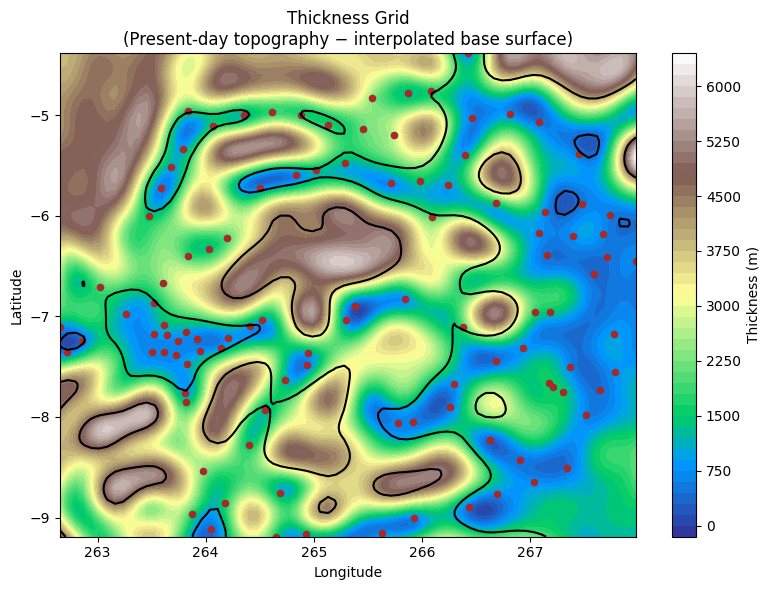

Maximum thickness: 6.33 km


In [12]:
# Compute thickness: present-day MOLA minus the interpolated base surface
difference_grid = grid_noctis[::-1] - grid_z_spline_b

#  2-D thickness map 
fig, ax = plt.subplots(figsize=(8, 6))

contourf_obj = ax.contourf(grid_x_b, grid_y_b, difference_grid,
                           cmap='terrain', levels=50, origin='upper')
ax.contour(grid_x_b, grid_y_b, grid_noctis[::-1], levels=2, colors='k', origin='upper')
ax.scatter(x_b, y_b, c='brown', s=20)

fig.colorbar(contourf_obj, ax=ax, label='Thickness (m)')
ax.set_xlim(np.min(grid_x_b), np.max(grid_x_b))
ax.set_ylim(np.min(grid_y_b), np.max(grid_y_b))
ax.set_title('Thickness Grid\n(Present-day topography − interpolated base surface)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

print(f'Maximum thickness: {np.max(difference_grid) / 1000:.2f} km')

np.save('difference_grid.npy', difference_grid)

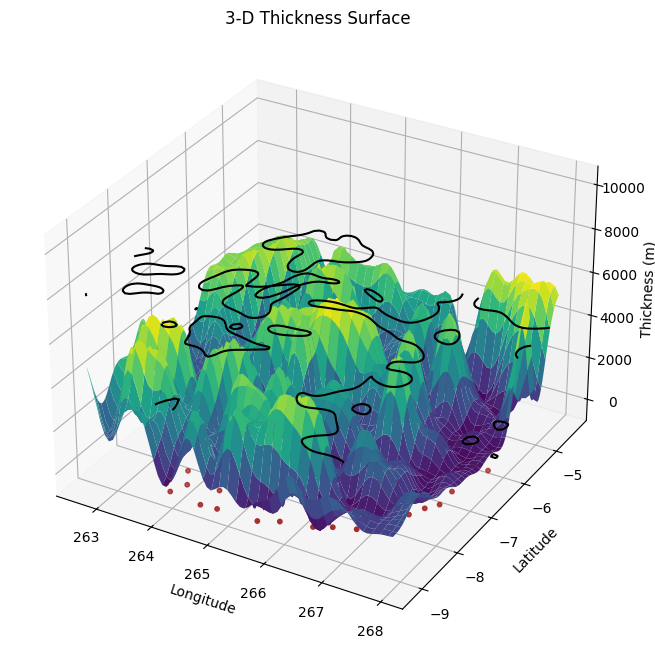

In [7]:
#  3-D surface visualisation of the thickness grid 
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid_x_b, grid_y_b, difference_grid, cmap='viridis')
ax.contour(grid_x_b, grid_y_b, grid_noctis[::-1], levels=2, colors='k', origin='upper')
ax.scatter(x_b, y_b, c='brown', s=10)

ax.set_title('3-D Thickness Surface')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Thickness (m)')
plt.show()

## 5. Raised Surface Interpolation

The high/raised elevation samples are interpolated using the same RBF approach as the base surface. This produces a continuous representation of the elevated terrain (e.g., volcanic flanks or ridge crests).

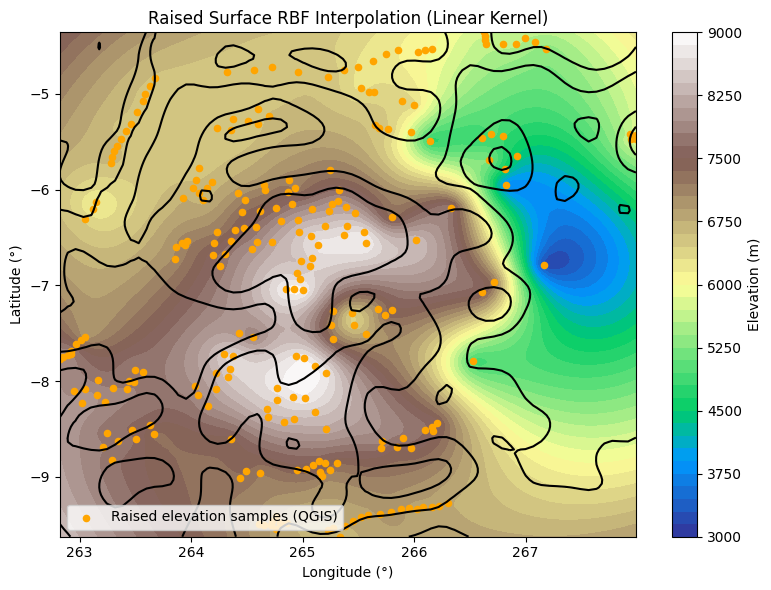

In [11]:
# Extract raised-surface sample coordinates and elevations
x = raised_layer['X'].values + 360
y = raised_layer['Y'].values
z = raised_layer['elevations'].values

# Create output grid matching the MOLA subgrid resolution
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), np.shape(grid_noctis)[1]),
    np.linspace(min(y), max(y), np.shape(grid_noctis)[0])
)

# RBF interpolation of the raised surface
rbf_interpolator = Rbf(x, y, z, function='linear')
grid_z_spline_r  = rbf_interpolator(grid_x, grid_y)

#  Plot: interpolated raised surface 
fig, ax2 = plt.subplots(1, figsize=(8, 6))

contour = ax2.contourf(grid_x, grid_y, grid_z_spline_r, cmap='terrain', levels=50)

# MOLA contour lines for geological context
ax2.contour(grid_x, grid_y, grid_noctis[::-1], levels=4, colors='k', origin='upper')

# Sample point locations
ax2.scatter(x, y, c='orange', s=20, label='Raised elevation samples (QGIS)')

fig.colorbar(contour, ax=ax2).set_label('Elevation (m)')
ax2.set_title('Raised Surface RBF Interpolation (Linear Kernel)')
ax2.set_xlabel('Longitude (°)')
ax2.set_ylabel('Latitude (°)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()